In [1]:
import pandas
import copy
import matplotlib

from src.utils import plot_truthtables, plot_growth_boxplot, plot_dilution_boxplot, plot_sensitivity_specificity, plot_comparison_tbprofiler

matplotlib.rcParams.update({'font.size': 7})

pandas.options.display.max_rows = 200

%load_ext autoreload
%autoreload 2

Set to `True` to save all figures in the `pdf/` folder.

In [2]:
savefig=False

Read in the large `RESULTS` table created in the previous notebook

In [3]:
results = pandas.read_csv('dat/RESULTS.csv')
results[:3]

,set,drug,method,dataset,quality,sensitivity,sensitivity_sem,specificity,specificity_sem,PPV,PPV_sem,RR,SR,UR,RS,SS,US,Total
0,basic,INH,UKMYC,bootstrap-0,ALL,88.803089,NaN,95.020747,NaN,95.041322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,basic,INH,UKMYC,bootstrap-0,HIGH,93.172691,NaN,96.414343,NaN,96.265560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,basic,INH,UKMYC,bootstrap-1,ALL,91.828794,NaN,94.650206,NaN,94.779116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
drug_names_table = pandas.read_csv("dat/drugs/drug_names_lookup.csv")
drug_names_table.set_index("DRUG", inplace=True)
drug_names_lookup = {}
for idx, row in drug_names_table.iterrows():
    drug_names_lookup[idx] = row.DRUG_NAME.capitalize()
drug_names_lookup

{'AMI': 'Amikacin',
 'BDQ': 'Bedaquiline',
 'CAP': 'Capreomycin',
 'CFZ': 'Clofazimine',
 'DLM': 'Delamanid',
 'EMB': 'Ethambutol',
 'ETH': 'Ethionamide',
 'INH': 'Isoniazid',
 'KAN': 'Kanamycin',
 'LEV': 'Levofloxacin',
 'LZD': 'Linezolid',
 'MXF': 'Moxifloxacin',
 'PZA': 'Pyrazinamide',
 'RFB': 'Rifabutin',
 'RIF': 'Rifampicin',
 'STM': 'Streptomycin'}

Now read in the list of drugs in the WHOv2 catalogue as well as the performance of the WHOv2 catalogue as reported in Annex 1 of the report

In [5]:
who_drugs = list(pandas.read_csv('dat/drugs/who2_drugs.csv').drug)

who = pandas.read_csv('dat/WHO2-Annex1-table.csv')
who = who[(who.catalogue=='WHO2') & (who.FRS==0.75)]

# reverse the order of the table so that the drugs are in the same order on all graphs
who = who.iloc[::-1]
who

,drug,catalogue,FRS,sensitivity,specificity,PPV,sensitivity_low,sensitivity_high,specificity_low,specificity_high,PPV_low,PPV_high
43,CAP,WHO2,0.75,66.2,97.8,80.1,64.1,68.2,97.6,98.1,78.1,81.9
40,KAN,WHO2,0.75,74.9,96.7,79.3,73.4,76.3,96.4,96.9,77.9,80.7
37,ETH,WHO2,0.75,74.8,85.9,63.9,73.6,76.0,85.3,86.4,62.7,65.1
34,STM,WHO2,0.75,79.7,94.1,89.9,78.9,80.5,93.7,94.4,89.3,90.5
31,AMI,WHO2,0.75,72.8,98.3,82.8,71.0,74.6,98.1,98.5,81.2,84.4
28,DLM,WHO2,0.75,14.7,99.9,72.5,10.6,19.7,99.8,99.9,58.3,84.1
25,CFZ,WHO2,0.75,17.0,98.7,38.1,14.2,20.0,98.5,98.9,32.6,43.8
22,LEV,WHO2,0.75,84.8,96.9,88.1,83.9,85.7,96.7,97.1,87.3,89.0
19,MXF,WHO2,0.75,85.7,93.5,74.0,84.6,86.8,93.2,93.9,72.7,75.2
16,LZD,WHO2,0.75,34.0,99.8,78.4,29.2,39.0,99.7,99.9,71.3,84.5


Now also produce a table for the UKMYC drugs with HIGH confidence MIC measurements. Because four drugs will not have values we have to manually insert the rows to ensure the graphs work.


In [6]:
summary = results[(results.dataset=='bootstrapped50') & (results.quality=='ALL')]

# reverse the order of the table so the drugs are in the correct order from top to bottom in the plot
summary = summary.iloc[::-1]


df2 = results[(results.dataset=='bootstrapped50') & (results.quality=='HIGH') & (results.set=='nulls+minors')]

rows = []
for i in ['PZA', 'BDQ', 'STM', 'CAP']:
    row = ['nulls+minor', i, 'UKMYC', 'bootstrapped50', 'HIGH'] + [None for i in range(13)]
    rows.append(row)

df3 = pandas.DataFrame(rows, columns=df2.columns)
df2 = pandas.concat([df2, df3])

df2.drug = df2.drug.astype('category')
df2.drug = df2.drug.cat.set_categories(who_drugs)
df2.sort_values('drug', inplace=True)
df2 = df2.iloc[::-1]
df2['set'] = 'nulls+minors+high'
df2

summary = pandas.concat([summary, df2])
summary[:3]

/var/folders/84/9nb2gsqj4hlcxztvwf19wg680000gq/T/ipykernel_21680/1426872962.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df2 = pandas.concat([df2, df3])


,set,drug,method,dataset,quality,sensitivity,sensitivity_sem,specificity,specificity_sem,PPV,PPV_sem,RR,SR,UR,RS,SS,US,Total
5406,tbprofiler,CAP,MGIT,bootstrapped50,ALL,73.778591,0.858111,98.356579,0.165979,95.263516,0.467160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5352,tbprofiler,KAN,UKMYC,bootstrapped50,ALL,75.792708,1.219868,98.773814,0.144725,96.108923,0.498343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5248,tbprofiler,ETH,UKMYC,bootstrapped50,ALL,76.163428,0.972133,85.782603,0.515811,68.869456,0.951987,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
summary.set.value_counts()

set
tbprofiler           15
nulls+minors         15
nulls                15
basic                15
nulls+minors+high    15
Name: count, dtype: int64

## Table 2, S2

Performance of gnomonicus

In [8]:
table = summary[summary.set.isin(['basic','nulls+minors','nulls+minors+high'])]
table = table[['set', 'drug', 'sensitivity',
       'sensitivity_sem', 'specificity', 'specificity_sem']]

for col in ['sensitivity', 'sensitivity_sem', 'specificity', 'specificity_sem']:
    table[col] = table[col].map('{:,.1f}'.format)
for col in ['sensitivity', 'specificity']:
    table[col] = table[col] + ' ±' + table[col+'_sem']
table = table[['set','drug', 'sensitivity',
        'specificity', ]]
table.drug = table.drug.astype('category')
table.drug = table.drug.cat.set_categories(who_drugs)
table.set = table.set.astype('category')
table.set = table.set.cat.set_categories(['basic', 'nulls+minors', 'nulls+minors+high'])
table.set_index(['set','drug'], inplace=True)
table = table.unstack(level=0)
table.columns = table.columns.swaplevel(0,1)
table.sort_index(axis=1, level=0, inplace=True)
table.replace('nan ±nan', '', inplace=True)
table.rename(drug_names_lookup, inplace=True)
table

set                basic             nulls+minors              \
             sensitivity specificity  sensitivity specificity   
drug                                                            
Isoniazid      91.4 ±0.5   95.3 ±0.4    92.8 ±0.5   94.4 ±0.4   
Rifampicin     94.3 ±0.5   96.0 ±0.3    95.7 ±0.4   95.0 ±0.4   
Pyrazinamide   81.7 ±0.7   97.4 ±0.3    85.8 ±0.7   97.0 ±0.4   
Ethambutol     85.5 ±0.8   84.7 ±0.6    87.3 ±0.8   83.7 ±0.6   
Bedaquiline    40.7 ±1.0   98.6 ±0.2    66.5 ±0.9   97.8 ±0.3   
Linezolid      22.4 ±1.9   99.9 ±0.1    29.2 ±2.1   99.8 ±0.1   
Moxifloxacin   81.4 ±0.8   94.6 ±0.3    86.7 ±0.7   93.9 ±0.3   
Levofloxacin   78.1 ±1.0   96.8 ±0.3    83.4 ±0.9   96.3 ±0.3   
Clofazimine     7.4 ±0.7   97.8 ±0.2    14.8 ±0.9   96.4 ±0.3   
Delamanid      12.1 ±1.2   99.9 ±0.0    12.9 ±1.2   99.9 ±0.0   
Amikacin       71.8 ±1.4   99.6 ±0.1    75.2 ±1.3   99.5 ±0.1   
Streptomycin   80.8 ±0.7   95.6 ±0.3    84.2 ±0.8   94.6 ±0.4   
Ethionamide    71.5 ±1.0   87.3 ±0.5    73.3 ±1.0   86.0 ±0.5   
Kanamycin      73.9 ±1.3   99.0 ±0.1    77.5 ±1.2   98.8 ±0.1   
Capreomycin    64.1 ±1.0   98.3 ±0.2    76.4 ±0.8   98.2 ±0.2   

set          nulls+minors+high              
                   sensitivity specificity  
drug                                        
Isoniazid            95.6 ±0.4   95.1 ±0.4  
Rifampicin           96.4 ±0.3   95.3 ±0.4  
Pyrazinamide                                
Ethambutol           90.5 ±0.6   81.5 ±0.6  
Bedaquiline                                 
Linezolid            45.0 ±2.2   99.8 ±0.1  
Moxifloxacin         90.5 ±0.7   93.2 ±0.4  
Levofloxacin         87.5 ±0.7   96.6 ±0.3  
Clofazimine          12.7 ±1.5   96.5 ±0.2  
Delamanid            21.4 ±2.0  100.0 ±0.0  
Amikacin             83.9 ±0.9   99.3 ±0.1  
Streptomycin                                
Ethionamide          77.9 ±0.9   85.3 ±0.5  
Kanamycin            85.4 ±0.8   98.4 ±0.1  
Capreomycin

In [9]:
print(table.to_latex(column_format='r|rr|rr|rr', multirow=True))

\begin{tabular}{r|rr|rr|rr}
\toprule
set & \multicolumn{2}{r}{basic} & \multicolumn{2}{r}{nulls+minors} & \multicolumn{2}{r}{nulls+minors+high} \\
 & sensitivity & specificity & sensitivity & specificity & sensitivity & specificity \\
drug &  &  &  &  &  &  \\
\midrule
Isoniazid & 91.4 ±0.5 & 95.3 ±0.4 & 92.8 ±0.5 & 94.4 ±0.4 & 95.6 ±0.4 & 95.1 ±0.4 \\
Rifampicin & 94.3 ±0.5 & 96.0 ±0.3 & 95.7 ±0.4 & 95.0 ±0.4 & 96.4 ±0.3 & 95.3 ±0.4 \\
Pyrazinamide & 81.7 ±0.7 & 97.4 ±0.3 & 85.8 ±0.7 & 97.0 ±0.4 &  &  \\
Ethambutol & 85.5 ±0.8 & 84.7 ±0.6 & 87.3 ±0.8 & 83.7 ±0.6 & 90.5 ±0.6 & 81.5 ±0.6 \\
Bedaquiline & 40.7 ±1.0 & 98.6 ±0.2 & 66.5 ±0.9 & 97.8 ±0.3 &  &  \\
Linezolid & 22.4 ±1.9 & 99.9 ±0.1 & 29.2 ±2.1 & 99.8 ±0.1 & 45.0 ±2.2 & 99.8 ±0.1 \\
Moxifloxacin & 81.4 ±0.8 & 94.6 ±0.3 & 86.7 ±0.7 & 93.9 ±0.3 & 90.5 ±0.7 & 93.2 ±0.4 \\
Levofloxacin & 78.1 ±1.0 & 96.8 ±0.3 & 83.4 ±0.9 & 96.3 ±0.3 & 87.5 ±0.7 & 96.6 ±0.3 \\
Clofazimine & 7.4 ±0.7 & 97.8 ±0.2 & 14.8 ±0.9 & 96.4 ±0.3 & 12.7 ±1.5 & 

In [10]:
table = summary[summary.set.isin(['basic','nulls+minors','nulls+minors+high'])]
table = table[['set', 'drug', 'PPV', 'PPV_sem']]
for col in ['PPV', 'PPV_sem']:
    table[col] = table[col].map('{:,.1f}'.format)
for col in ['PPV']:
    table[col] = table[col] + ' ±' + table[col+'_sem']
table = table[['set','drug', 'PPV']]
table.drug = table.drug.astype('category')
table.drug = table.drug.cat.set_categories(who_drugs)
table.set = table.set.astype('category')
table.set = table.set.cat.set_categories(['basic', 'nulls+minors', 'nulls+minor+high'])
table.set_index(['set','drug'], inplace=True)
table = table.unstack(level=0)
table.columns = table.columns.swaplevel(0,1)
table.sort_index(axis=1, level=0, inplace=True)
table.replace('nan ±nan', '', inplace=True)
table.rename(drug_names_lookup, inplace=True)
table

set,basic,nulls+minors,nan
,PPV,PPV,PPV
drug,,,
Isoniazid,95.2 ±0.4,94.4 ±0.4,95.3 ±0.3
Rifampicin,95.6 ±0.4,94.7 ±0.4,95.5 ±0.4
Pyrazinamide,96.4 ±0.5,96.1 ±0.5,
Ethambutol,69.3 ±1.0,68.5 ±1.0,67.4 ±0.9
Bedaquiline,96.8 ±0.5,97.0 ±0.3,
Linezolid,95.9 ±1.8,94.2 ±1.6,96.1 ±1.2
Moxifloxacin,86.0 ±0.9,85.3 ±0.9,86.2 ±0.8
Levofloxacin,92.0 ±0.7,91.6 ±0.7,92.5 ±0.6


In [11]:
print(table.to_latex(column_format='r|rr|rr|rr', multirow=True))

\begin{tabular}{r|rr|rr|rr}
\toprule
set & basic & nulls+minors & NaN \\
 & PPV & PPV & PPV \\
drug &  &  &  \\
\midrule
Isoniazid & 95.2 ±0.4 & 94.4 ±0.4 & 95.3 ±0.3 \\
Rifampicin & 95.6 ±0.4 & 94.7 ±0.4 & 95.5 ±0.4 \\
Pyrazinamide & 96.4 ±0.5 & 96.1 ±0.5 &  \\
Ethambutol & 69.3 ±1.0 & 68.5 ±1.0 & 67.4 ±0.9 \\
Bedaquiline & 96.8 ±0.5 & 97.0 ±0.3 &  \\
Linezolid & 95.9 ±1.8 & 94.2 ±1.6 & 96.1 ±1.2 \\
Moxifloxacin & 86.0 ±0.9 & 85.3 ±0.9 & 86.2 ±0.8 \\
Levofloxacin & 92.0 ±0.7 & 91.6 ±0.7 & 92.5 ±0.6 \\
Clofazimine & 57.9 ±3.4 & 61.8 ±2.4 & 31.6 ±2.8 \\
Delamanid & 93.7 ±3.0 & 94.0 ±2.9 & 100.0 ±0.0 \\
Amikacin & 98.6 ±0.3 & 98.2 ±0.4 & 98.1 ±0.4 \\
Streptomycin & 92.8 ±0.6 & 91.6 ±0.6 &  \\
Ethionamide & 69.8 ±0.9 & 68.3 ±0.9 & 68.9 ±0.9 \\
Kanamycin & 96.8 ±0.4 & 96.2 ±0.5 & 95.8 ±0.4 \\
Capreomycin & 94.3 ±0.6 & 95.1 ±0.5 &  \\
\bottomrule
\end{tabular}



## Figures 1, S1

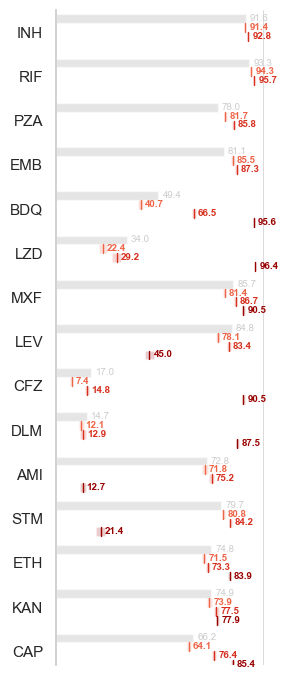

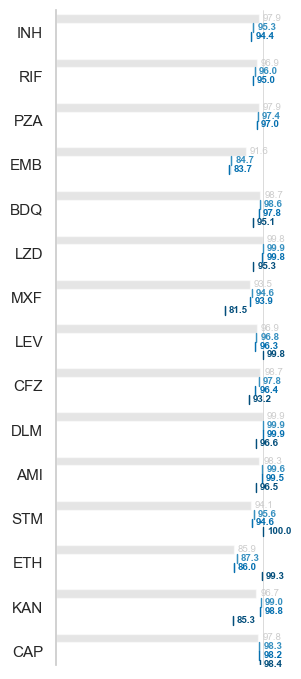

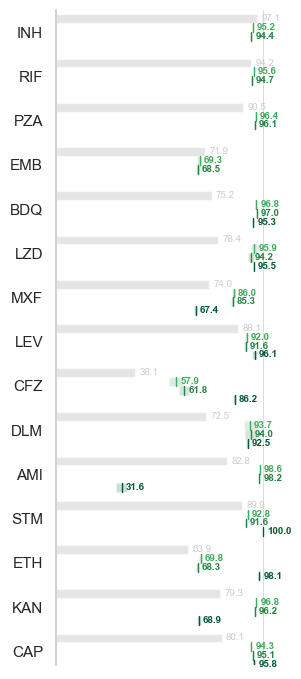

In [12]:
plot_sensitivity_specificity(summary, who, savefig=savefig)

## Figures S2, S3

In [13]:
for set in ['basic', 'nulls', 'nulls+minors', "tbprofiler"]:

    df = results[(results.set==set)]

    plot_truthtables(df, ['ALL','HIGH'], filestem=f'table-{set}-', savefig=savefig)


In [14]:
UKMYC_PHENOTYPES = pandas.read_csv('dat/UKMYC_1000_phenotypes.csv')
UKMYC_PHENOTYPES.set_index('ENA_RUN_ACCESSION', inplace=True)

UKMYC_SAMPLES = pandas.read_csv('dat/UKMYC_1000_samples.csv')
UKMYC_SAMPLES.set_index('ENA_RUN_ACCESSION', inplace=True)

UKMYC_PHENOTYPES = UKMYC_PHENOTYPES.join(UKMYC_SAMPLES[['POS_AVG_GROWTH']])
UKMYC_PHENOTYPES.reset_index(inplace=True)
UKMYC_PHENOTYPES.set_index(['ENA_RUN_ACCESSION', 'DRUG'], inplace=True)
UKMYC_PHENOTYPES[:3]

PREDICTIONS = pandas.read_csv('dat/PREDICTIONS.csv')
tbprofiler = pandas.read_csv('dat/tbprofiler_PREDICTIONS.csv')
tbprofiler["SET"] = "tbprofiler"
PREDICTIONS = PREDICTIONS._append(tbprofiler, ignore_index=True)
PREDICTIONS.set_index(['ENA_RUN_ACCESSION', 'DRUG'], inplace=True)
PREDICTIONS[:3]

UKMYC_RESULTS = UKMYC_PHENOTYPES.join(PREDICTIONS,how='inner')
UKMYC_RESULTS.reset_index(inplace=True)
UKMYC_RESULTS[:3]

def define_outcome(row):
    if row.PREDICTION in ['S', 'U']:
        if row.BINARY_PHENOTYPE == 'R':
            return '(S+U)R'
        else:
            return '(S+U)S'
    else:
        return str(row.PREDICTION)+str(row.BINARY_PHENOTYPE)

UKMYC_RESULTS['OUTCOME'] = UKMYC_RESULTS.apply(define_outcome, axis=1)
UKMYC_RESULTS.OUTCOME.value_counts()

OUTCOME
(S+U)S    33009
RR         9546
(S+U)R     3818
RS         1505
FS           18
FR            8
Name: count, dtype: int64

In [15]:
DISCREPANCY_SET = UKMYC_RESULTS[(UKMYC_RESULTS.PHENOTYPE_METHOD=='UKMYC') & (UKMYC_RESULTS.OUTCOME.str[0]!='F')]
DISCREPANCY_SET[:6]

,ENA_RUN_ACCESSION,DRUG,UNIQUEID,BINARY_PHENOTYPE,PHENOTYPE_QUALITY,PHENOTYPE_METHOD,PLATEDESIGN,MIC,DILUTION,POS_AVG_GROWTH,SET,PREDICTION,OUTCOME
0,ERR4810791,INH,site.02.subj.0068.lab.22A018.iso.1,R,HIGH,UKMYC,UKMYC5,>1.6,8,44.68,basic,R,RR
1,ERR4810791,INH,site.02.subj.0068.lab.22A018.iso.1,R,HIGH,UKMYC,UKMYC5,>1.6,8,44.68,nulls,R,RR
2,ERR4810791,INH,site.02.subj.0068.lab.22A018.iso.1,R,HIGH,UKMYC,UKMYC5,>1.6,8,44.68,nulls+minors,R,RR
3,ERR4810791,INH,site.02.subj.0068.lab.22A018.iso.1,R,HIGH,UKMYC,UKMYC5,>1.6,8,44.68,tbprofiler,R,RR
4,ERR4810791,RIF,site.02.subj.0068.lab.22A018.iso.1,R,HIGH,UKMYC,UKMYC5,>4,8,44.68,basic,R,RR
5,ERR4810791,RIF,site.02.subj.0068.lab.22A018.iso.1,R,HIGH,UKMYC,UKMYC5,>4,8,44.68,nulls,R,RR


In [16]:
for set in ['basic', 'nulls', 'nulls+minors']:
    for drug in DISCREPANCY_SET.DRUG.unique():
        for quality in ['HIGH','ALL']:
            if quality=='HIGH':
                df = copy.deepcopy(DISCREPANCY_SET[(DISCREPANCY_SET.SET==set) & (DISCREPANCY_SET.DRUG==drug) & (DISCREPANCY_SET.PHENOTYPE_QUALITY==quality)])
            else:

                df = copy.deepcopy(DISCREPANCY_SET[(DISCREPANCY_SET.SET==set) & (DISCREPANCY_SET.DRUG==drug)])
            plot_growth_boxplot(df, filename=f'growth-{set}-{drug}-{quality}.pdf', savefig=savefig)

In [17]:
for set in ['basic', 'nulls', 'nulls+minors']:
    for platedesign in ['UKMYC5', 'UKMYC6']:
        for drug in DISCREPANCY_SET.DRUG.unique():
            for quality in ['HIGH','ALL']:
                if quality=='HIGH':
                    df = copy.deepcopy(DISCREPANCY_SET[(DISCREPANCY_SET.SET==set) & (DISCREPANCY_SET.PLATEDESIGN==platedesign) & (DISCREPANCY_SET.DRUG==drug) & (DISCREPANCY_SET.PHENOTYPE_QUALITY==quality)])
                else:

                    df = copy.deepcopy(DISCREPANCY_SET[(DISCREPANCY_SET.SET==set) & (DISCREPANCY_SET.PLATEDESIGN==platedesign) & (DISCREPANCY_SET.DRUG==drug)])
                if df.empty:
                    continue
                plot_dilution_boxplot(df, filename=f'mic-{set}-{drug}-{platedesign}-{quality}', savefig=savefig)

## Figure 2

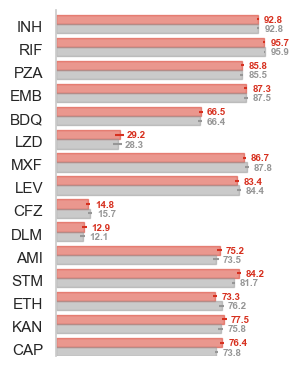

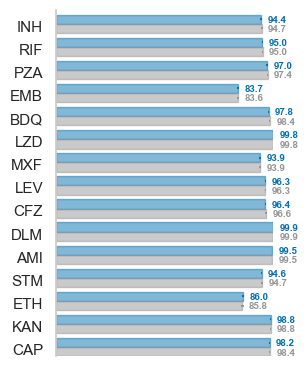

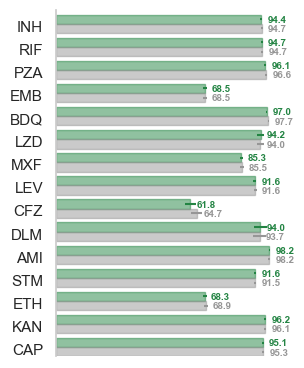

In [18]:
plot_comparison_tbprofiler(summary, savefig=savefig)